# Planners

#### 'Planning' is a the process of figuring out specific actions that need to be pieced together to accomplish a task.

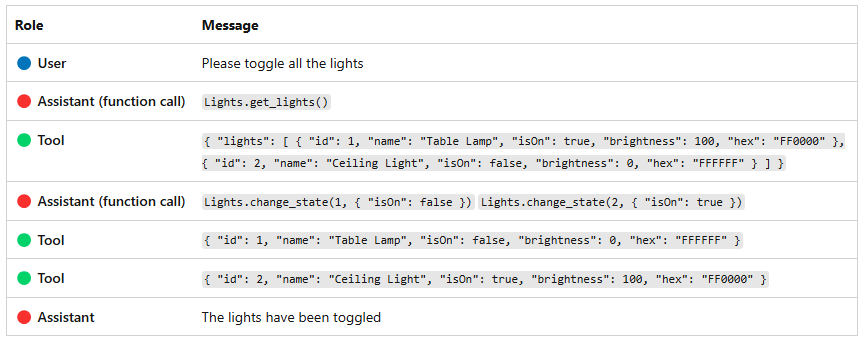

In [3]:
#r "nuget: Microsoft.SemanticKernel, 1.45.0"
#r "nuget: Microsoft.SemanticKernel.PromptTemplates.Handlebars, 1.45.0"
#r "nuget: Microsoft.SemanticKernel.Yaml, 1.45.0"
#r "nuget: Microsoft.SemanticKernel.Plugins.OpenApi, 1.45.0"

Installed Packages Microsoft.SemanticKernel, 1.45.0 Microsoft.SemanticKernel.Plugins.OpenApi, 1.45.0 Microsoft.SemanticKernel.PromptTemplates.Handlebars, 1.45.0 Microsoft.SemanticKernel.Yaml, 1.45.0

In [5]:
using System;
using System.Collections.Generic;
using System.Text.Json;
using System.Text.Json.Serialization;
using System.ComponentModel;
using Microsoft.SemanticKernel;

public class Light
{
    [JsonPropertyName("id")]
    public int Id { get; set; }

    [JsonPropertyName("name")]
    public string Name { get; set; }

    [JsonPropertyName("isOn")]
    public bool IsOn { get; set; }

    [JsonPropertyName("brightness")]
    public int Brightness { get; set; }

    [JsonPropertyName("hex")]
    public string Hex { get; set; }
}

public class LightsPlugin
{
    private static Light tableLamp = new Light
            {
                Id = 1,
                Name = "Table Lamp",
                IsOn = true,
                Brightness = 100,
                Hex = "FF0000"
            };

    private static Light ceilingLight = new Light
            {
                Id = 2,
                Name = "Ceiling Light",
                IsOn = false,
                Brightness = 0,
                Hex = "FFFFFF"
            };
    [KernelFunction]
    [Description("Get the list of lights")]
    public List<Light> GetLights()
    {
        return new List<Light>
            { ceilingLight, tableLamp };                
    }

    [KernelFunction]
    [Description("Turns the light ON")]
    public Light TurnOnLight([Description("Id the of the light to be switched on")]int id)
    {
        if ( id ==  1)
        {
            tableLamp.IsOn = true;
            tableLamp.Brightness = 100;
            return tableLamp;
        }
        else if ( id ==  2)
        {
            ceilingLight.IsOn = true;
            ceilingLight.Brightness = 100;
            return ceilingLight;
        }
        else
        {
            throw new ArgumentException("Invalid light ID.");
        } 
    }
    [KernelFunction]
    [Description("Turns the light off")]
    public Light TurnOffLight([Description("Id the of the light to be switched off")]int id)
    {
         if ( id ==  1)
        {
            tableLamp.IsOn = false;
            tableLamp.Brightness = 0;
            return tableLamp;
        }
        else if ( id ==  2)
        {
            ceilingLight.IsOn = false;
            ceilingLight.Brightness = 0;
            return ceilingLight;
        }
        else
        {
            throw new ArgumentException("Invalid light ID.");
        } 
    }
}

##### Use the availabls tools and execute the plan.

In [ ]:
using System.ComponentModel;
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.ChatCompletion;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using Kernel = Microsoft.SemanticKernel.Kernel;
#!import config/Settings.cs 

var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();
var builder = Kernel.CreateBuilder();
builder.AddOpenAIChatCompletion(model, apiKey, orgId);
builder.Plugins.AddFromType<LightsPlugin>("Lights");
Kernel kernel = builder.Build();

var chatCompletionService = kernel.GetRequiredService<IChatCompletionService>();

// 2. Enable automatic function calling
OpenAIPromptExecutionSettings openAIPromptExecutionSettings = new() 
{
    FunctionChoiceBehavior = FunctionChoiceBehavior.Auto()
};

var history = new ChatHistory();
int maxCount = 3;
string? userInput;
do {
    // Collect user input    
    userInput = "Toggle all lights. Explain what you did.";

    // Add user input
    history.AddUserMessage(userInput);

    // 3. Get the response from the AI with automatic function calling
    var result = await chatCompletionService.GetChatMessageContentAsync(
        history,
        executionSettings: openAIPromptExecutionSettings,
        kernel: kernel);

    // Print the results
    Console.WriteLine("Assistant > " + result);

    // Add the message from the agent to the chat history
    history.AddMessage(result.Role, result.Content ?? string.Empty);
} while (maxCount-- > 0);